In [70]:
import pandas as pd
import numpy as np
import sklearn.cluster
import distance
import csv
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from collections import Counter
import pprint
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from gensim import corpora, models
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer

In [71]:
pp = pprint.PrettyPrinter(indent=4)
p_stemmer = PorterStemmer()
wnl = WordNetLemmatizer()

In [72]:
with open('AnalysisData.csv') as data_file:    
    data = csv.DictReader(data_file, delimiter=',', quotechar='"')
    data.next
raw_data = open('AnalysisData.csv', 'rb')
reader = csv.reader(raw_data, delimiter=',', quoting=csv.QUOTE_MINIMAL)
x = list(reader)
for i in xrange(len(x)):
    del x[i][4]
    del x[i][3]
    del x[i][0]

http://chrisalbon.com/python/cleaning_text.html

In [73]:
for i in xrange(len(x)):
    from_word = x[i][0]
    
    if '-' in from_word and from_word.index('-') == 2:
        x[i][0] = from_word[3:].lower()

In [74]:
regex = re.compile('[%s]' % re.escape(string.punctuation))
for i in xrange(len(x)):
    
    tokenized_sms = word_tokenize(x[i][1])
    tokenized_sms_optimized = []
    
    for tokenized_word in tokenized_sms:

        new_tokenized_word = []
        for tokenized_character in tokenized_word: 
            new_tokenized_character = regex.sub('', tokenized_character)
            if not new_tokenized_character == '':
                new_tokenized_word.append(new_tokenized_character)
        if new_tokenized_word:
            new_tokenized_word = "".join(new_tokenized_word).lower()
            if not new_tokenized_word in stopwords.words('english'):
                tokenized_sms_optimized.append(wnl.lemmatize(wnl.lemmatize(new_tokenized_word, 'v')))
    
    x[i][1] = " ".join(tokenized_sms_optimized)

In [75]:
data = np.array(x)
df = pd.DataFrame(x)

http://chrisalbon.com/python/pandas_list_unique_values_in_column.html

In [76]:
pp.pprint(df.shape)
from_unique_list = list(df.get(0).unique())
print("Unique From: " + str(len(from_unique_list)))
print("Unique SMS: " + str(len(df.get(1).unique())))

(6784, 2)
Unique From: 835
Unique SMS: 5598


In [77]:
from_unique_dict = {i:x for i, x in enumerate(from_unique_list)}
from_unique_dict.update({x:i for i, x in enumerate(from_unique_list)})

if len(from_unique_dict) == len(from_unique_list)*2:
    print("Successfully created unique dictionary from FROM data of sms")
else:
    print("Some FROM data is equal to number assigned to it")

from_count = Counter(df.get(0))
print("\nCount of sms from each sender")
#pp.pprint(from_count.most_common(n=30))

sms_words_count = Counter()
df.get(1).str.lower().str.split().apply(sms_words_count.update)
print("\nCount of words in all sms")
#pp.pprint(sms_words_count.most_common(n=30))

Successfully created unique dictionary from FROM data of sms

Count of sms from each sender

Count of words in all sms


In [95]:
hv = HashingVectorizer()
hv.transform(df.get(1))
vectorizer = TfidfVectorizer(min_df=1)
tf_transform = vectorizer.fit_transform(df.get(1))
tf_transform

<6784x1048576 sparse matrix of type '<type 'numpy.float64'>'
	with 106708 stored elements in Compressed Sparse Row format>

https://rstudio-pubs-static.s3.amazonaws.com/79360_850b2a69980c4488b1db95987a24867a.html

In [11]:
texts = df.get(1).str.split(" ")
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [ ]:
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=10, id2word = dictionary, passes=300)

In [47]:
ldamodel = gensim.models.ldamodel.LdaModel.load("lda_model_10_topics_300_passes_13Feb_4am")

In [78]:
#pp.pprint(ldamodel.print_topics(num_topics=5, num_words=4))

In [116]:
pp.pprint(ldamodel.save("lda_model_10_topics_300_passes_13Feb_4am"))

None


In [48]:
from operator import itemgetter

topic_distribution = []
for x in ldamodel.get_document_topics(corpus):
    topic_distribution.append((max(x,key=itemgetter(1))[0], max(x,key=itemgetter(1))[1]))

In [49]:
import matplotlib.pyplot as plt
%matplotlib inline

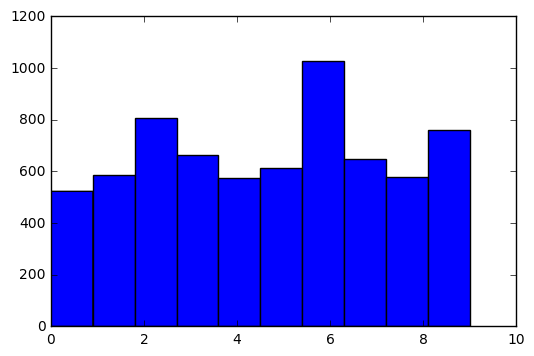

In [50]:
topics = zip(*topic_distribution)[0]
y = np.array(list(topics))
plt.hist(y);
plt.show()

In [69]:
topic_sms = []
for i,x in enumerate(topic_distribution):
    if x[0] == 10 and x[1] > 0.9:
        topic_sms.append(i)
for x in topic_sms:
    pp.pprint(df.get_values()[x])